# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


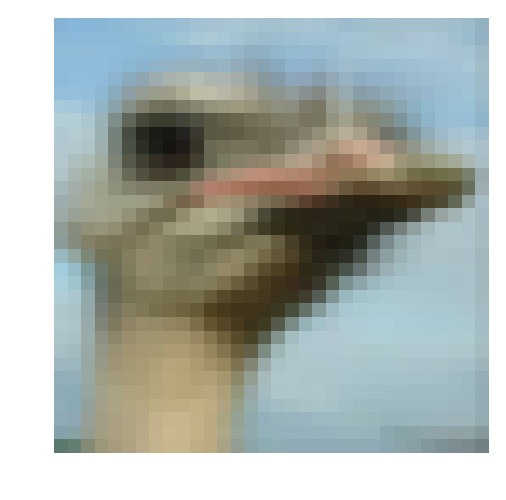

In [3]:
# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess Data

In [4]:
def normalize(x):
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)

def one_hot_encode(x):
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [5]:
import pickle
import helper

# Load the Preprocessed Validation data for cifar-10
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [2]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [3]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [4]:
class Network(object):
    
    def __init__(self, x_dim, n_classes, p_l1_w, p_l1_b, p_l2_w, p_l2_b):
        # Inputs
        self.p_l1_w = p_l1_w
        self.p_l1_b = p_l1_b
        self.p_l2_w = p_l2_w
        self.p_l2_b = p_l2_b
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.int64, [None, 10], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.Variable(self.p_l1_w, dtype=tf.float32, name='l1_w')
        self.l1_b = tf.Variable(self.p_l1_b, dtype=tf.float32, name='l1_b')
        self.l2_w = tf.Variable(self.p_l2_w, dtype=tf.float32, name='l2_w')
        self.l2_b = tf.Variable(self.p_l2_b, dtype=tf.float32, name='l2_b')

    def build(self):
        l1_a = tf.sigmoid(tf.nn.bias_add(tf.matmul(self.x, self.l1_w), self.l1_b))
        logits = tf.nn.bias_add(tf.matmul(l1_a, self.l2_w), self.l2_b)
        return logits

In [5]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [6]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

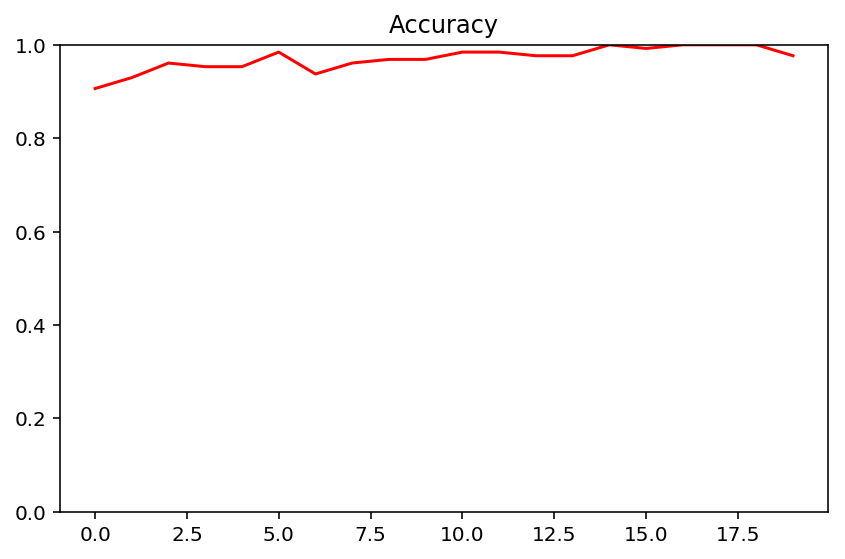

In [7]:
batch_size = 128
x_dim = 784
n_classes = 10
epochs = 20

with tf.Session() as sess:
    
    l1_w = [[truncated_normal() for _ in range(100)] for _ in range(x_dim)]
    l1_b = np.zeros(100)
    l2_w = [[truncated_normal() for _ in range(10)] for _ in range(100)]
    l2_b = np.zeros(10)

    net = Network(x_dim, n_classes, l1_w, l1_b, l2_w, l2_b)
    sess.run(tf.global_variables_initializer())
    accuracies = []
    # Initializing the variables
    for e in range(epochs):
        batch_num = mnist.train.num_examples//batch_size
        for ii in range(batch_num):
            train_batch, labels = mnist.train.next_batch(batch_size)
            train_batch = train_batch*2-1

            # Run optimizers
            feed_dict = {net.x:train_batch,
                         net.y:labels}
            _ = sess.run([net.optimizer], feed_dict=feed_dict)
            logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)
            
        accuracies.append(accuracy)

    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(epochs), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [8]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from operator import attrgetter
import string
import random
import time

In [9]:
__DEBUG__ = False
batch_size = 64
x_dim = 784
n_classes = 10

In [10]:
class Individual(object):
    
    def __init__(self, generation):
        self.accuracy = -1
        self.evaluation_time = 0.0
        self.generation = generation
                
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
    def generate(self):
        self.gene = {}
        # l1_w 
        self.gene[0] = np.random.randn(x_dim, 100)
        # l1_b 
        self.gene[1] = np.random.randn(100)
        # l2_w 
        self.gene[2] = np.random.randn(100, 10)
        # l2_b 
        self.gene[3] = np.random.randn(10)
        
    def fitness(self):
        tf.reset_default_graph()
        with tf.Session() as sess:
            net = Network(x_dim, 
                          n_classes,
                          self.gene[0],
                          self.gene[1], 
                          self.gene[2], 
                          self.gene[3])
            sess.run(tf.global_variables_initializer())
            
            values = []
            batch_num = mnist.train.num_examples//batch_size
            for ii in range(batch_num):
                train_batch, labels = mnist.train.next_batch(batch_size)
                # Run optimizers
                feed_dict = {net.x: train_batch,
                             net.y: labels}
                values += sess.run([net.accuracy], feed_dict=feed_dict)
            self.accuracy = np.mean(values)

    def cross_over(self, parent, recombination_probability=.5):
        child = {}
        # Complete Continuous Recombination
        child[0] = (self.gene[0][:] + parent.gene[0][:])/2.
        child[1] = (self.gene[1][:] + parent.gene[1][:])/2.
        child[2] = (self.gene[2][:] + parent.gene[2][:])/2.
        child[3] = (self.gene[3][:] + parent.gene[3][:])/2.
        
        ''' 
        # Continuous Recombination
        for ii, g in enumerate(child[0]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[0][ii] = (g + parent.gene[0][ii])/2.
    
        for ii, g in enumerate(child[1]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[1][ii] = (g + parent.gene[1][ii])/2.
        
        for ii, g in enumerate(child[2]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[2][ii] = (g + parent.gene[2][ii])/2.
        
        for ii, g in enumerate(child[3]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[3][ii] = (g + parent.gene[3][ii])/2.
        '''
                    
        individ = Individual(generation=self.generation)
        individ.gene = child
        return individ
        
    def mutate(self, mutation_rate=.05):
        prob = np.random.sample()

        if prob <= mutation_rate:
            tf.reset_default_graph()
            with tf.Session() as sess:
                net = Network(x_dim, 
                              n_classes,
                              self.gene[0],
                              self.gene[1], 
                              self.gene[2], 
                              self.gene[3])
                sess.run(tf.global_variables_initializer())
                
                batch_num = mnist.train.num_examples//batch_size
                for ii in range(batch_num):
                    train_batch, labels = mnist.train.next_batch(batch_size)
                    # Run optimizers
                    feed_dict = {net.x: train_batch,
                                 net.y: labels}
                    _ = sess.run([net.optimizer], feed_dict=feed_dict)
                self.gene[0] = sess.run(net.l1_w)
                self.gene[1] = sess.run(net.l1_b)
                self.gene[2] = sess.run(net.l2_w)
                self.gene[3] = sess.run(net.l2_b)
        

In [17]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.99):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []

    def _evaluate_best_(self):
        self.current_best_individual = self._evaluate_current_best_individual_()
        self.current_best_solution = self.current_best_individual.accuracy
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament._evaluate_current_best_individual_()
    
    def _evaluate_current_best_individual_(self):
        return max(self.population, key=attrgetter('accuracy'))
    
    def evaluate_fitnesses(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.accuracy < 0:
                p.fitness()
                print('{}/{}, Accuracy {}'.format(i+1, 
                                                  population_length, 
                                                  p.accuracy))
        self._evaluate_best_()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self.evaluate_fitnesses()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_accuracy(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Solution accuracy: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_solution))    

In [18]:
# hypter-parameters
max_generations = 100
population_size = 20
mutation_rate = 1.

In [19]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    accuracies = []
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_accuracy()
        accuracies.append(population.global_best_individual.accuracy)
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal accuracy: {}, Generation: {}'.format(
        population.generation, 
        best_individual.accuracy, 
        best_individual.generation))
    
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(len(accuracies)), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    return best_individual

1/20, Accuracy 0.14011569321155548
2/20, Accuracy 0.07865250110626221
3/20, Accuracy 0.10271754860877991
4/20, Accuracy 0.11370415985584259
5/20, Accuracy 0.09509604424238205
6/20, Accuracy 0.11048457771539688
7/20, Accuracy 0.09180369973182678
8/20, Accuracy 0.07570575922727585
9/20, Accuracy 0.12479991465806961
10/20, Accuracy 0.06708382070064545
11/20, Accuracy 0.07505092769861221
12/20, Accuracy 0.14320795238018036
13/20, Accuracy 0.07750654965639114
14/20, Accuracy 0.12352663278579712
15/20, Accuracy 0.07263169437646866
16/20, Accuracy 0.13365831971168518
17/20, Accuracy 0.09775174409151077
18/20, Accuracy 0.11121216416358948
19/20, Accuracy 0.10482756048440933
20/20, Accuracy 0.11648719757795334
Generation: 1/100, Solution accuracy: 0.14320795238018036
2/21, Accuracy 0.14089784026145935
3/21, Accuracy 0.07736103236675262
4/21, Accuracy 0.13458600640296936
5/21, Accuracy 0.15850552916526794
6/21, Accuracy 0.11037543416023254
7/21, Accuracy 0.11070284992456436
8/21, Accuracy 0.0738

2/21, Accuracy 0.9188554883003235
3/21, Accuracy 0.9183098077774048
4/21, Accuracy 0.9183825850486755
5/21, Accuracy 0.9185099005699158
6/21, Accuracy 0.9190555810928345
7/21, Accuracy 0.9193648099899292
8/21, Accuracy 0.9174367189407349
9/21, Accuracy 0.9189828038215637
10/21, Accuracy 0.919237494468689
11/21, Accuracy 0.9176185727119446
12/21, Accuracy 0.9195830821990967
13/21, Accuracy 0.9172729849815369
14/21, Accuracy 0.9205289483070374
15/21, Accuracy 0.9178550839424133
16/21, Accuracy 0.9180187582969666
17/21, Accuracy 0.9197103977203369
18/21, Accuracy 0.918673574924469
19/21, Accuracy 0.9181460738182068
20/21, Accuracy 0.9184553027153015
21/21, Accuracy 0.9188191294670105
Generation: 12/100, Solution accuracy: 0.9205289483070374
2/21, Accuracy 0.9198559522628784
3/21, Accuracy 0.9174912571907043
4/21, Accuracy 0.9186190366744995
5/21, Accuracy 0.9189828038215637
6/21, Accuracy 0.9182734489440918
7/21, Accuracy 0.9194739460945129
8/21, Accuracy 0.9180551767349243
9/21, Accuracy

2/21, Accuracy 0.9490141272544861
3/21, Accuracy 0.9476680755615234
4/21, Accuracy 0.9489231705665588
5/21, Accuracy 0.9478499889373779
6/21, Accuracy 0.9479045271873474
7/21, Accuracy 0.949887216091156
8/21, Accuracy 0.9476680755615234
9/21, Accuracy 0.9494143128395081
10/21, Accuracy 0.9482137560844421
11/21, Accuracy 0.9482319355010986
12/21, Accuracy 0.9485048055648804
13/21, Accuracy 0.9480500817298889
14/21, Accuracy 0.9488503932952881
15/21, Accuracy 0.9494688510894775
16/21, Accuracy 0.9476498961448669
17/21, Accuracy 0.9488322138786316
18/21, Accuracy 0.9478681683540344
19/21, Accuracy 0.9485775828361511
20/21, Accuracy 0.9492142200469971
21/21, Accuracy 0.9482137560844421
Generation: 23/100, Solution accuracy: 0.949887216091156
2/21, Accuracy 0.9482865333557129
3/21, Accuracy 0.9485593438148499
4/21, Accuracy 0.9495961666107178
5/21, Accuracy 0.947049617767334
6/21, Accuracy 0.9493597149848938
7/21, Accuracy 0.9480318427085876
8/21, Accuracy 0.9484502077102661
9/21, Accuracy 

2/21, Accuracy 0.9624017477035522
3/21, Accuracy 0.962201714515686
4/21, Accuracy 0.9623472094535828
5/21, Accuracy 0.962274432182312
6/21, Accuracy 0.9617287516593933
7/21, Accuracy 0.96243816614151
8/21, Accuracy 0.9627655744552612
9/21, Accuracy 0.9616559743881226
10/21, Accuracy 0.9678950905799866
11/21, Accuracy 0.9626200795173645
12/21, Accuracy 0.962238073348999
13/21, Accuracy 0.9612194299697876
14/21, Accuracy 0.9633840322494507
15/21, Accuracy 0.9618924856185913
16/21, Accuracy 0.9621471166610718
17/21, Accuracy 0.962874710559845
18/21, Accuracy 0.9616377949714661
19/21, Accuracy 0.9631293416023254
20/21, Accuracy 0.9615832567214966
21/21, Accuracy 0.9621107578277588
Generation: 34/100, Solution accuracy: 0.9678950905799866
2/21, Accuracy 0.9668219089508057
3/21, Accuracy 0.9686590433120728
4/21, Accuracy 0.9618924856185913
5/21, Accuracy 0.9619470238685608
6/21, Accuracy 0.9662761688232422
7/21, Accuracy 0.9659305810928345
8/21, Accuracy 0.9670401811599731
9/21, Accuracy 0.9

2/21, Accuracy 0.9684044122695923
3/21, Accuracy 0.9673857688903809
4/21, Accuracy 0.9686954021453857
5/21, Accuracy 0.9666036367416382
6/21, Accuracy 0.967949628829956
7/21, Accuracy 0.9679860472679138
8/21, Accuracy 0.9677131772041321
9/21, Accuracy 0.9673129916191101
10/21, Accuracy 0.9676222205162048
11/21, Accuracy 0.9680042266845703
12/21, Accuracy 0.9671493172645569
13/21, Accuracy 0.9680042266845703
14/21, Accuracy 0.9674585461616516
15/21, Accuracy 0.96875
16/21, Accuracy 0.9668764472007751
17/21, Accuracy 0.9682406783103943
18/21, Accuracy 0.9666945338249207
19/21, Accuracy 0.968786358833313
20/21, Accuracy 0.9674039483070374
21/21, Accuracy 0.9682588577270508
Generation: 45/100, Solution accuracy: 0.969550371170044
2/21, Accuracy 0.9665126800537109
3/21, Accuracy 0.967949628829956
4/21, Accuracy 0.9678587317466736
5/21, Accuracy 0.9677495360374451
6/21, Accuracy 0.9676586389541626
7/21, Accuracy 0.9675495028495789
8/21, Accuracy 0.9671856760978699
9/21, Accuracy 0.9682224988

2/21, Accuracy 0.9740068316459656
3/21, Accuracy 0.9728972911834717
4/21, Accuracy 0.9737340211868286
5/21, Accuracy 0.9735339283943176
6/21, Accuracy 0.9729518294334412
7/21, Accuracy 0.9735884666442871
8/21, Accuracy 0.9735339283943176
9/21, Accuracy 0.9737340211868286
10/21, Accuracy 0.974625289440155
11/21, Accuracy 0.9723333716392517
12/21, Accuracy 0.9736794233322144
13/21, Accuracy 0.9736976027488708
14/21, Accuracy 0.974461555480957
15/21, Accuracy 0.9726789593696594
16/21, Accuracy 0.9733156561851501
17/21, Accuracy 0.9738795161247253
18/21, Accuracy 0.9733701944351196
19/21, Accuracy 0.9741159677505493
20/21, Accuracy 0.9731337428092957
21/21, Accuracy 0.9736430644989014
Generation: 56/100, Solution accuracy: 0.974625289440155
2/21, Accuracy 0.9726971983909607
3/21, Accuracy 0.9744433760643005
4/21, Accuracy 0.9735521078109741
5/21, Accuracy 0.9727153778076172
6/21, Accuracy 0.9739158749580383
7/21, Accuracy 0.9736066460609436
8/21, Accuracy 0.9741341471672058
9/21, Accuracy 

2/21, Accuracy 0.9779903888702393
3/21, Accuracy 0.9784815311431885
4/21, Accuracy 0.9778448939323425
5/21, Accuracy 0.9785178899765015
6/21, Accuracy 0.9781904816627502
7/21, Accuracy 0.97806316614151
8/21, Accuracy 0.978299617767334
9/21, Accuracy 0.9781177043914795
10/21, Accuracy 0.9785178899765015
11/21, Accuracy 0.97806316614151
12/21, Accuracy 0.9785906672477722
13/21, Accuracy 0.9779358506202698
14/21, Accuracy 0.978299617767334
15/21, Accuracy 0.9777539372444153
16/21, Accuracy 0.9789908528327942
17/21, Accuracy 0.9778084754943848
18/21, Accuracy 0.978099524974823
19/21, Accuracy 0.978463351726532
20/21, Accuracy 0.9789362549781799
21/21, Accuracy 0.9779903888702393
Generation: 67/100, Solution accuracy: 0.9790818095207214
2/21, Accuracy 0.9783542156219482
3/21, Accuracy 0.9786270260810852
4/21, Accuracy 0.9777539372444153
5/21, Accuracy 0.9784269332885742
6/21, Accuracy 0.9802459478378296
7/21, Accuracy 0.9779903888702393
8/21, Accuracy 0.9784269332885742
9/21, Accuracy 0.977

2/21, Accuracy 0.9821012616157532
3/21, Accuracy 0.9817193150520325
4/21, Accuracy 0.9824104905128479
5/21, Accuracy 0.9814646244049072
6/21, Accuracy 0.9829744100570679
7/21, Accuracy 0.981701135635376
8/21, Accuracy 0.9820285439491272
9/21, Accuracy 0.9820103049278259
10/21, Accuracy 0.9822831749916077
11/21, Accuracy 0.9823923110961914
12/21, Accuracy 0.981573760509491
13/21, Accuracy 0.9823013544082642
14/21, Accuracy 0.9824286699295044
15/21, Accuracy 0.9818466305732727
16/21, Accuracy 0.9820285439491272
17/21, Accuracy 0.981773853302002
18/21, Accuracy 0.9825924038887024
19/21, Accuracy 0.9818284511566162
20/21, Accuracy 0.9824286699295044
21/21, Accuracy 0.9818102717399597
Generation: 78/100, Solution accuracy: 0.9830107688903809
2/21, Accuracy 0.9821376800537109
3/21, Accuracy 0.9821558594703674
4/21, Accuracy 0.9821376800537109
5/21, Accuracy 0.9820830821990967
6/21, Accuracy 0.9819921255111694
7/21, Accuracy 0.9821376800537109
8/21, Accuracy 0.9820467233657837
9/21, Accuracy 

2/21, Accuracy 0.9835019111633301
3/21, Accuracy 0.9835019111633301
4/21, Accuracy 0.9834473133087158
5/21, Accuracy 0.9836292266845703
6/21, Accuracy 0.9832653999328613
7/21, Accuracy 0.983974814414978
8/21, Accuracy 0.9832290410995483
9/21, Accuracy 0.9838474988937378
10/21, Accuracy 0.9830835461616516
11/21, Accuracy 0.983938455581665
12/21, Accuracy 0.9835019111633301
13/21, Accuracy 0.9835200905799866
14/21, Accuracy 0.9835019111633301
15/21, Accuracy 0.9834109544754028
16/21, Accuracy 0.9836474061012268
17/21, Accuracy 0.9834473133087158
18/21, Accuracy 0.9837020039558411
19/21, Accuracy 0.9835200905799866
20/21, Accuracy 0.9833381772041321
21/21, Accuracy 0.9835564494132996
Generation: 89/100, Solution accuracy: 0.984211266040802
2/21, Accuracy 0.983738362789154
3/21, Accuracy 0.9831926822662354
4/21, Accuracy 0.9838293194770813
5/21, Accuracy 0.9833927750587463
6/21, Accuracy 0.9838838577270508
7/21, Accuracy 0.9831562638282776
8/21, Accuracy 0.9836292266845703
9/21, Accuracy 0

2/21, Accuracy 0.9849206805229187
3/21, Accuracy 0.9858483672142029
4/21, Accuracy 0.9848297238349915
5/21, Accuracy 0.9846842288970947
6/21, Accuracy 0.984811544418335
7/21, Accuracy 0.9849025011062622
8/21, Accuracy 0.9858483672142029
9/21, Accuracy 0.9847933650016785
10/21, Accuracy 0.9858847260475159
11/21, Accuracy 0.9847933650016785
12/21, Accuracy 0.9848843216896057
13/21, Accuracy 0.9847933650016785
14/21, Accuracy 0.9857755899429321
15/21, Accuracy 0.9859393239021301
16/21, Accuracy 0.984775185585022
17/21, Accuracy 0.9848843216896057
18/21, Accuracy 0.9858847260475159
19/21, Accuracy 0.9847933650016785
20/21, Accuracy 0.9847933650016785
21/21, Accuracy 0.9849206805229187
Generation: 100/100, Solution accuracy: 0.9861575961112976

Completed 100 generations:
Final accuracy: 0.9861575961112976, Generation: 97


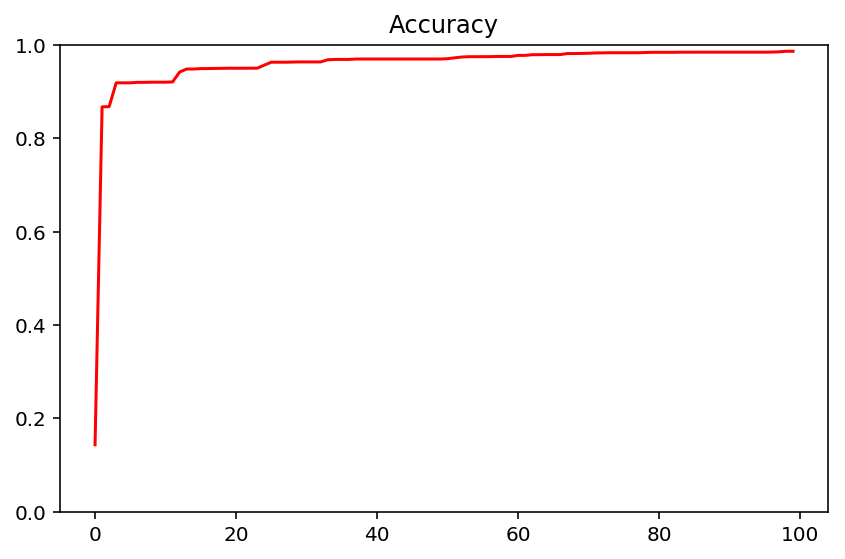

In [20]:
best_individ = execute(max_generations, population_size, mutation_rate)

## Test Model - MNIST

In [21]:
with tf.Session() as sess:
    net = Network(x_dim, 
                  n_classes,
                  best_individ.gene[0],
                  best_individ.gene[1], 
                  best_individ.gene[2], 
                  best_individ.gene[3])
    sess.run(tf.global_variables_initializer())

    values = []
    batch_num = mnist.test.num_examples//batch_size
    for ii in range(batch_num):
        train_batch, labels = mnist.test.next_batch(batch_size)
        # Run optimizers
        feed_dict = {net.x: train_batch,
                     net.y: labels}
        values += sess.run([net.accuracy], feed_dict=feed_dict)
    accuracy = np.mean(values)
    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.964343


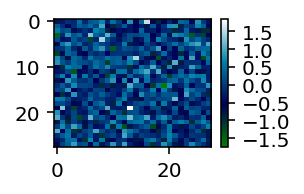

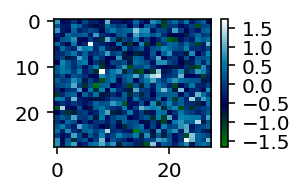

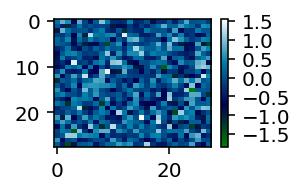

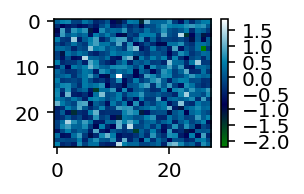

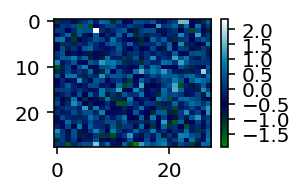

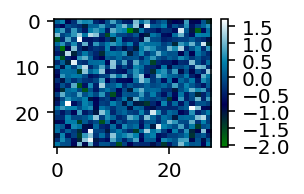

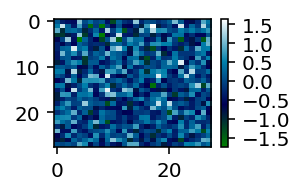

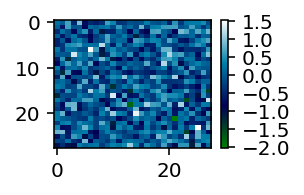

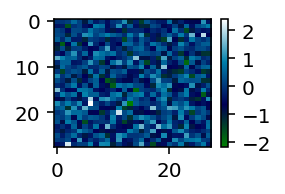

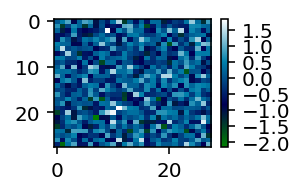

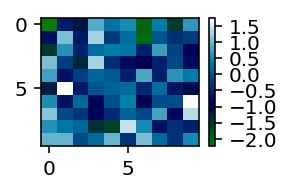

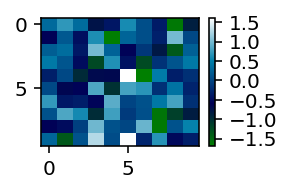

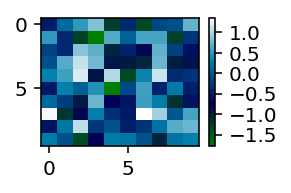

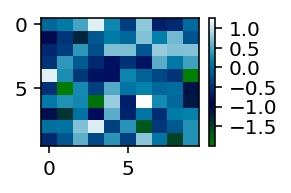

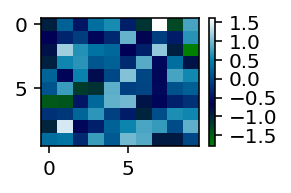

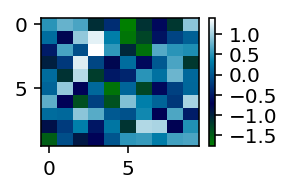

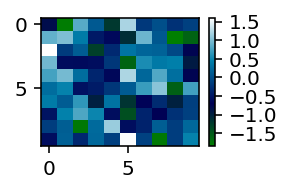

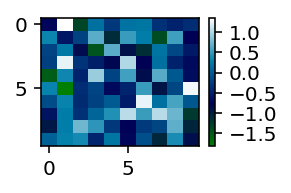

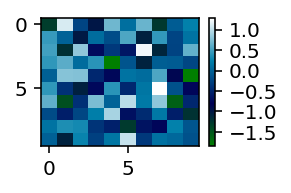

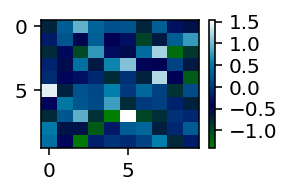

In [22]:
mat_a = np.reshape(best_individ.gene[0], (-1, 28, 28))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_a[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

mat_b = np.reshape(best_individ.gene[2], (-1, 10, 10))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_b[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

In [23]:
best_individ.gene[2]

array([[ -2.20827818e+00,  -6.05012298e-01,  -1.12123561e+00,
          8.72944117e-01,   3.09391439e-01,   5.61934650e-01,
         -1.92442262e+00,   4.08150822e-01,  -1.51473749e+00,
          6.91071451e-01],
       [ -7.27584362e-01,   1.06347096e+00,  -6.19446874e-01,
          1.26753819e+00,  -2.74698317e-01,   2.39964083e-01,
         -1.97906411e+00,   3.10348719e-03,  -4.09764796e-01,
         -2.67405242e-01],
       [ -1.48136985e+00,   6.19121313e-01,  -5.31900525e-01,
          2.49111578e-01,   4.16495800e-01,   3.34500074e-01,
         -5.48441231e-01,   7.21124172e-01,  -1.85989484e-01,
         -8.68159175e-01],
       [  1.08024287e+00,  -2.56939650e-01,  -1.29392195e+00,
          1.30223095e+00,  -4.13497210e-01,  -7.65136719e-01,
         -8.86125326e-01,  -5.44241190e-01,  -1.41463906e-01,
         -7.76205599e-01],
       [  7.71523058e-01,  -6.77088499e-01,  -2.21186414e-01,
          1.75015152e-01,   3.04459967e-02,  -5.24070382e-01,
          8.32516253e-01

## Test Model - CIFAR10

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6319665605095541



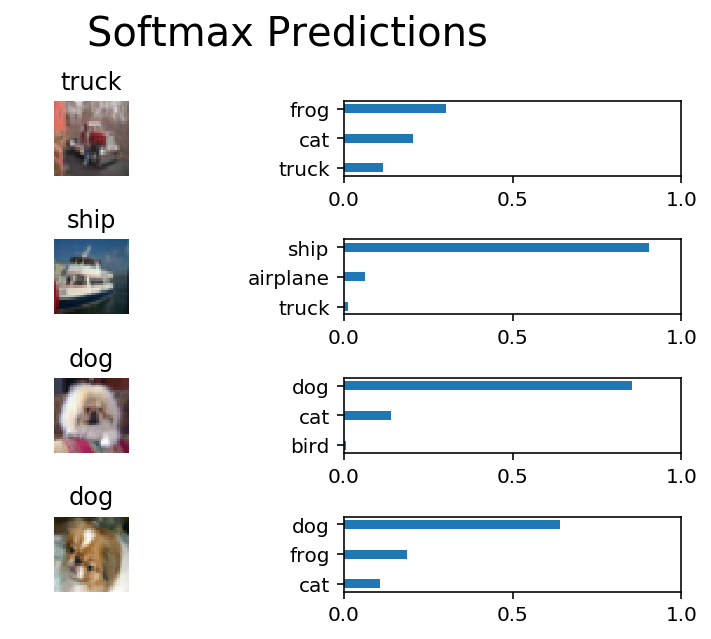

In [29]:
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()